In [ ]:
# import dependencies
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False
plt.rc('font', size=18)
plt.rcParams['figure.figsize'] = [10, 7]

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors2 =  plt.cm.tab20( (np.arange(20)).astype(int) )
from numpy.polynomial import polynomial as poly
from scipy import signal, stats, integrate, linalg

Mounted at /content/drive
/content/drive/MyDrive


In [ ]:
model_str='fcc_model_64r'
weights=np.load('weights/dynamic_weights_'+model_str+'.npy')
pcomp=np.load('pc/mc_'+model_str+'.npy')
model=tf.keras.models.load_model('saved_model/'+model_str)
layer_name=model.d2
layer_shape=layer_name.get_weights()[0].shape
values_mean=np.mean(weights,axis=0)
layer_size=1
for i in layer_name.get_weights()[0].shape:
    layer_size*=i

In [ ]:
# load the data set
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train,x_test=x_train/255,x_test/255
# normalise the data

for i in range(x_train.shape[0]):
    x_train[i]-=np.mean(x_train[i],axis=(0,1))
    x_train[i]/=np.std(x_train[i],axis=(0,1))
for i in range(x_test.shape[0]):
    x_test[i]-=np.mean(x_test[i],axis=(0,1))
    x_test[i]/=np.std(x_test[i],axis=(0,1))

In [ ]:
w_0, b = layer_name.get_weights()
theta_last=np.tensordot(pcomp,w_0.flatten(),axes=(1,0))

In [ ]:
# adding the principal components together up to ith indices
def sum_weights(i):
    templ=np.zeros(pcomp.shape[1])
    for j in tf.range(i):
        templ+=theta_last[j]*pcomp[j]
    return templ

In [ ]:
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
@tf.function
def calc_acc(images, labels):
    test_accuracy.reset_states()
    predictions = model(images, training=False)
    test_acc=test_accuracy(labels, predictions)
    tf.print(test_acc)
    return test_acc

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
train_loss = tf.keras.metrics.Mean(name='train_loss')
@tf.function
def calc_loss(images, labels):
    train_loss.reset_states()
    predictions = model(images, training=False)
    loss=loss_object(labels, predictions)
    loss+=sum(model.losses)
    return train_loss(loss)

In [ ]:
# calculates the train accuracy and loss for a batch of the total set
train_acc=np.zeros(pcomp.shape[0])
loss=np.empty(pcomp.shape[0])
for i in range(pcomp.shape[0]):
    layer_name.set_weights([sum_weights(i).reshape(layer_shape),b])
    train_acc[i]=calc_acc(x_train[:2048], y_train[:2048])
    loss[i]=calc_loss(x_train[:2048], y_train[:2048])

0.104492188
0.239746094
0.236328125
0.239746094
0.243652344
0.23828125
0.25
0.252929688
0.267089844
0.260742188
0.262207031
0.263671875
0.266601562
0.267578125
0.26953125
0.270019531
0.26953125
0.260253906
0.261230469
0.262207031
0.254882812
0.256347656
0.254882812
0.256835938
0.259277344
0.265625
0.261230469
0.262695312
0.262207031
0.261230469
0.259765625
0.255371094
0.25390625
0.254394531
0.255371094
0.257324219
0.259765625
0.25390625
0.255859375
0.253417969
0.255371094
0.253417969
0.252441406
0.256835938
0.25390625
0.249511719
0.248046875
0.250488281
0.251953125
0.252929688
0.25390625
0.25390625
0.254394531
0.250488281
0.250488281
0.250488281
0.247070312
0.24609375
0.247070312
0.249023438
0.24609375
0.248046875
0.249023438
0.250976562
0.251464844
0.245117188
0.247558594
0.247558594
0.249511719
0.254394531
0.252441406
0.25390625
0.250976562
0.250488281
0.245117188
0.243164062
0.243652344
0.250976562
0.251464844
0.247558594
0.252441406
0.254394531
0.253417969
0.253417969
0.251464844
0

In [ ]:
# calculates the test accuracy
acc=np.empty(pcomp.shape[0])
for i in range(pcomp.shape[0]):
    layer_name.set_weights([sum_weights(i).reshape(layer_shape),b])
    acc[i]=calc_acc(x_test, y_test)

0.1
0.0964
0.1053
0.1315
0.3729
0.3741
0.3745
0.3746
0.3755
0.3753
0.3747
0.3753
0.3751
0.3746
0.3742
0.3738
0.3738
0.3735
0.374
0.3747
0.3748
0.3747
0.3743
0.3747
0.3751
0.3753
0.3748
0.3747
0.3747
0.3747
0.3744
0.3744
0.3739
0.3739
0.374


KeyboardInterrupt: ignored

In [ ]:
np.save('accs/test_acc_'+model_str,acc)
np.save('accs/train_acc_'+model_str,train_acc)
np.save('accs/loss_'+model_str,loss)

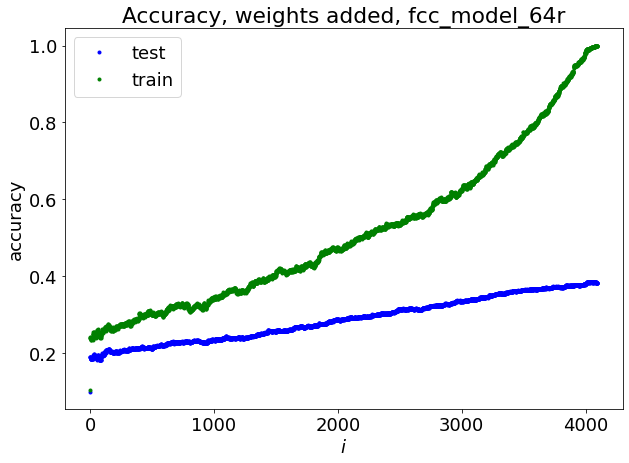

In [ ]:
plt.plot(acc,'b.', label='test')
plt.plot(train_acc,'g.', label='train')
plt.title(r"Accuracy, weights added, mc, "+model_str)
plt.ylabel(r"accuracy")
plt.xlabel(r"$i$")
plt.legend()
plt.savefig('plots/acc_both_mc_'+model_str+'.jpg')

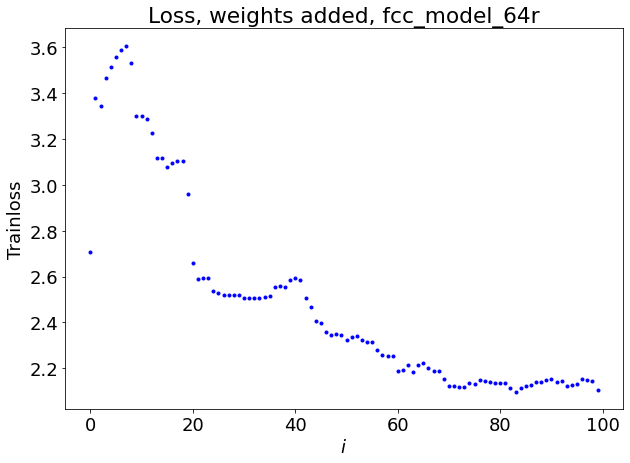

In [ ]:
plt.plot(loss[:100],'b.')
plt.title(r"Loss, weights added, "+model_str)
plt.ylabel(r"Trainloss")
plt.xlabel(r"$i$")
plt.savefig('plots/loss_'+model_str+'_z.jpg')
#plt.legend()

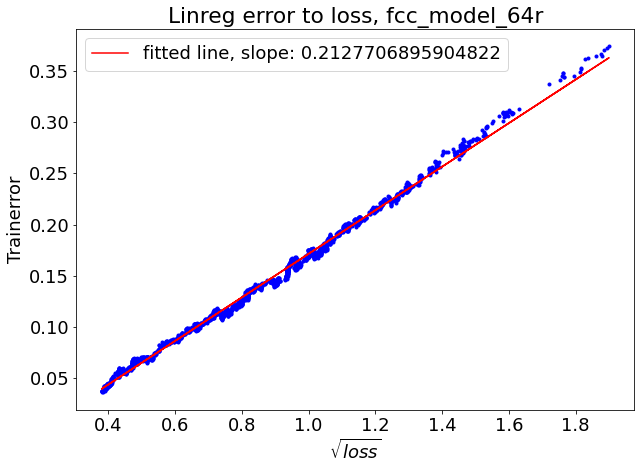

In [ ]:
plt.plot(np.sqrt(loss[1:3000]),1-acc[1:3000],'b.')
res = stats.linregress(np.sqrt(loss)[1:3000], 1-acc[1:3000])
plt.plot(np.sqrt(loss)[1:3000], (res.intercept + res.slope*np.sqrt(loss))[1:3000], 'r', label='fitted line, slope: '+str(res.slope))
plt.title(r"Linreg error to loss, "+model_str)
plt.ylabel(r"Trainerror")
plt.xlabel(r"$\sqrt{loss}$")
plt.legend()
plt.savefig('plots/loss_acc_fit_'+model_str+'.jpg')
